# Background
This file contains the code that were used to analyze the trend of temperature trend analysis of Koshi Basin for the paper that was submited to SOHAM.

First of all data were collected from Department of Hydrology Nepal for the koshi basin of all available stations and arranged in a single `csv` file.

### Importing all the required packages

In [26]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pykrige
import statsmodels.api as sm
from geopandas.tools import sjoin
import seaborn as sns
import pandas as pd
import scipy.stats 
import pymannkendall as mk
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, OffsetBox
import contextily as cx
from eomaps import Maps
import matplotlib.patches as mpatches
from scipy.stats import linregress
import numpy as np
import pandas as pd
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from shapely.geometry import Point

### Preparation of shape file
Koshi basin for the study area is prepared based on the putting outlet point at chatara sunsari.

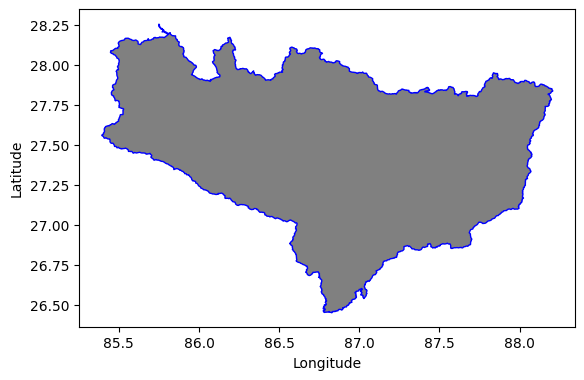

In [2]:
shapefile_path1 = r"G:\fresh_start\paper\code_paper\arcgis\base_gis_data\Koshi_Boundary.shp"

shapefile_path2 = r"G:\fresh_start\paper\code_paper\arcgis\base_gis_data\Saptaei_Boundary.shp"
# Reading shapefiles

gdf1 = gpd.read_file(shapefile_path1)
gdf2 = gpd.read_file(shapefile_path2)
# Concatenate (combine) the shapefiles
combined_shapefile = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))
combined_shapefile['poly_name'] = 'Basin'
combine_polygon = combined_shapefile[combined_shapefile['poly_name']=='Basin']
combined_basin = combine_polygon.dissolve(by='poly_name')

# viewing the prepared shape file
fig, ax = plt.subplots()
combined_basin.plot(ax=ax, facecolor='gray', edgecolor='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Set the aspect ratio manually to a finite positive value
ax.set_aspect('equal')  # or any other suitable aspect ratio
plt.show()

<Axes: >

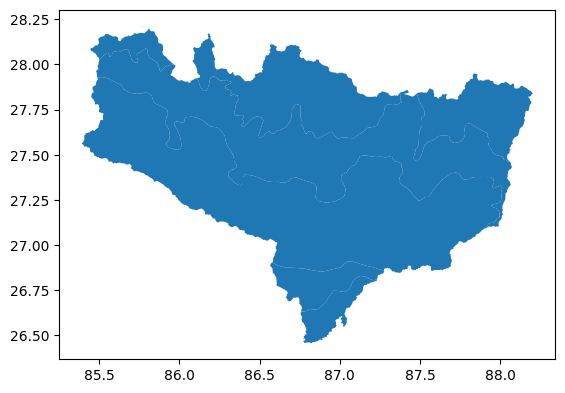

In [3]:
# Load the Nepal and Koshi basin shapefiles
nepal_shapefile_path = r'G:\fresh_start\paper\code_paper\arcgis\whole_nepal\Physiography\Physiography_Nepal.shp'
gdf_nepal = gpd.read_file(nepal_shapefile_path)
gdf_koshi_basin  = combined_basin.copy()
# Ensure both GeoDataFrames have the same CRS (Coordinate Reference System)
if gdf_nepal.crs != gdf_koshi_basin.crs:
    gdf_koshi_basin = gdf_koshi_basin.to_crs(gdf_nepal.crs)

# Perform spatial intersection to get the part of Nepal within the Koshi Basin
gdf_nepal_in_koshi = gpd.overlay(gdf_nepal, gdf_koshi_basin, how='intersection')
gdf_nepal_in_koshi.plot()

### Staion list
Preparing station details that were taken for data analysis

In [4]:
# Importing obtained data from DHM
stn_df = pd.read_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\daily_avg_1962.csv")
# Importing all station  data from DHM
all_npl_stn_list = pd.read_excel(r"G:\fresh_start\paper\code_paper\main_data\raw_data\Meteorological_station_list.xlsx")
all_npl_stn_list = all_npl_stn_list.rename(columns={"Index No.": "station"})
# Extract unique stations with regions, latitude, longitude, and elevation
unique_stations = stn_df[['station', 'regions', 'lat', 'long', 'elevation']].drop_duplicates()

# Display the unique station info
filtered_data = pd.merge(unique_stations, all_npl_stn_list, on='station', how='left')

selected_columns = ['station','Station Name', 'regions', 'lat', 'long', 'elevation']
filtered_data = filtered_data[selected_columns]
# There is one station with no staion number thats why it was replaced by 9999 as station number

filtered_data.loc[filtered_data['station'] == 9999, 'Station Name' ] = 'Lubuche'
#filtered_data.to_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\final_stations_koshi.csv", index=False)


In [5]:
stations = filtered_data.copy()
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['long'], stations['lat'])]
gdf_stations = gpd.GeoDataFrame(stations, geometry=geometry)

# Set coordinate reference system (CRS) if known; otherwise, default is EPSG:4326
gdf_stations.crs = "EPSG:4326"

In [6]:
stations_table = stations.copy()
stations_table['regions'] = stations_table['regions'].replace({
    'High Mountain': 'Himalaya',
    'Middle Mountain': 'High Mountain',
    'Hill': 'Middle Mountain'
})
region_mapping = {
    'Tarai': 'TAR',
    'Himalaya': 'H',
    'Middle Mountain': 'MM',
    'High Mountain': 'HM',
    'Siwalik': 'SW'
}
stations_table['Physiographic Regions'] = stations_table['regions'].map(region_mapping)

# Rearrange columns as per the desired format
stations_table = stations_table[['station', 'Station Name', 'lat', 'long', 'elevation', 'Physiographic Regions']]

# Rename columns
stations_table.columns = ['Station No.', 'Station Name', 'Latitude (°N)', 'Longitude (°E)', 'Elevation (m)', 'Physiographic Regions']

# Display the formatted table
print(stations_table)

    Station No.        Station Name  Latitude (°N)  Longitude (°E)  \
0          1316             Chatara      26.820440       87.159170   
1          1201        Namche Bazar      27.816670       86.716670   
2          1401        Olangchuhg G      27.683330       87.783330   
3          1225          Syangboche      27.816670       86.716670   
4          1218           Tengboche      27.833330       86.766670   
5          1206         Okhaldhunga      27.308121       86.504225   
6          1405           Taplejung      27.358611       87.670000   
7          1103                Jiri      27.630447       86.232114   
8          1036           Panchkhal      27.645134       85.620881   
9          1016          Sarmathang      27.944561       85.595136   
10         1123            Manthali      27.394703       86.061233   
11         1124               Kabre      27.633333       86.133333   
12         1212            Phatepur      26.730538       86.934812   
13         1219     

In [7]:
gdf_basin = gdf_nepal_in_koshi.copy()

# Rename the column 'DESCRIPTIO' to 'DESCRIPTION'
gdf_basin = gdf_basin.rename(columns={'DESCRIPTIO': 'DESCRIPTION'})
# Replace values in the 'DESCRIPTION' column
gdf_basin['DESCRIPTION'] = gdf_basin['DESCRIPTION'].replace({
    'High Mountain': 'Himalaya',
    'Middle Mountain': 'High Mountain',
    'Hill': 'Middle Mountain'
})

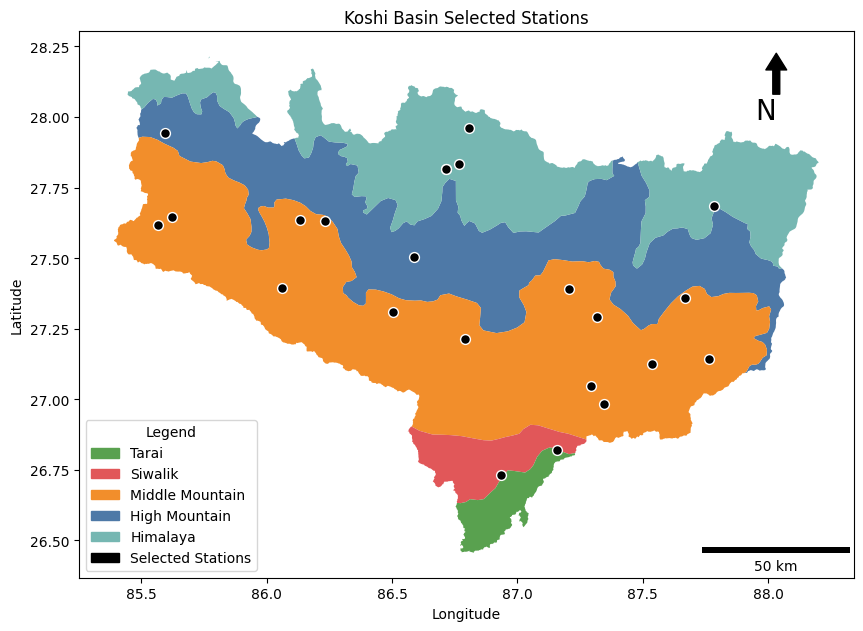

In [8]:

# Step 4: Plot the data
fig, ax = plt.subplots(figsize=(10, 10), alpha = 0.5, edgecolor = "k")

color_map = {
    'Tarai': '#59A14F',            # Natural Green
    'Siwalik': '#E15759',          # Soft Red
    'Middle Mountain': '#F28E2B',             # Warm Orange
    'High Mountain': '#4E79A7',  # Soft Blue
    'Himalaya': '#76B7B2',    # Gentle Teal
    
}

for regions, data in gdf_basin.groupby('DESCRIPTION'):
    color = color_map[regions]
    data.plot(
        color=color,
        ax=ax,
        )


# Plot the stations
gdf_stations.plot(ax=ax, color='black', markersize=50, edgecolor='white', label='Selected Stations')
# Add legend


# Add titles and labels
ax.set_title('Koshi Basin Selected Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Add a scale bar

points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar((distance_meters), location ="lower right"))


x, y, arrow_length = 0.9, 0.96, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)


# Step 2: Create custom legend handles for the regions and stations

# Handles for the regions
legend_handles_regions = [mpatches.Patch(color=color, label=region) for region, color in color_map.items()]

# Handle for the stations
legend_handle_stations = mpatches.Patch(color='black', label='Selected Stations')

# Combine both sets of handles
all_legend_handles = legend_handles_regions + [legend_handle_stations]

# Add the combined legend
ax.legend(handles=all_legend_handles, title="Legend", loc='lower left', bbox_to_anchor=(0, 0))

ax.grid(False)

#plt.savefig(r"G:\fresh_start\paper\code_paper\plots\study_area\koshi_basin_selected_station_study_area_map.png", dpi=1500, bbox_inches='tight')
# Show plot
plt.show()

# Results 
This section focus on preparation of results lets first clean the data.

In [9]:
for_nan_fill_df = pd.read_csv(r'G:\fresh_start\paper\code_paper\main_data\raw_data\df33333333_Nan.csv')

for_nan_fill_df['date'] = pd.to_datetime(for_nan_fill_df['date'])
print(for_nan_fill_df)

             date  station        regions        lat       long  elevation  \
0      1962-01-01     1316          Tarai  26.820440  87.159170      105.0   
1      1962-01-02     1316          Tarai  26.820440  87.159170      105.0   
2      1962-01-03     1316          Tarai  26.820440  87.159170      105.0   
3      1962-01-04     1316          Tarai  26.820440  87.159170      105.0   
4      1962-01-05     1316          Tarai  26.820440  87.159170      105.0   
...           ...      ...            ...        ...        ...        ...   
512534 2022-12-27     9999  High Mountain  27.961111  86.808889     5200.0   
512535 2022-12-28     9999  High Mountain  27.961111  86.808889     5200.0   
512536 2022-12-29     9999  High Mountain  27.961111  86.808889     5200.0   
512537 2022-12-30     9999  High Mountain  27.961111  86.808889     5200.0   
512538 2022-12-31     9999  High Mountain  27.961111  86.808889     5200.0   

             Tmin      Tmax  
0             NaN       NaN  
1  

In [10]:

df11_merged = for_nan_fill_df.copy()  

# List of unique stations
stations = df11_merged['station'].unique()

# Function to calculate IQR and replace outliers with NaN
def replace_outliers_with_nan(data, column):
    Q1 = data[column].quantile(0.25)  # 25th percentile
    Q3 = data[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound
    upper_bound = Q3 + 1.5 * IQR  # Upper bound

    # Replace values outside the bounds with NaN, keeping original NaN values
    data.loc[:,column] = data[column].where((data[column].isna()) | 
                                      ((data[column] >= lower_bound) & (data[column] <= upper_bound)), 
                                      other=pd.NA)
    return data

# Iterate over each station and apply outlier replacement for Tmin and Tmax
for station in stations:
    # Filter data for the current station
    station_data = df11_merged[df11_merged['station'] == station]
    
    # Apply the outlier replacement for both Tmin and Tmax columns
    station_data = replace_outliers_with_nan(station_data, 'Tmin')
    station_data = replace_outliers_with_nan(station_data, 'Tmax')
    
    # Update the original dataframe with the filtered station data
    df11_merged.loc[df11_merged['station'] == station] = station_data

# Reset the index if needed
df11_merged.reset_index(drop=True, inplace=True)



### Lapse rate Equation

$$ T_{cal} = T_{obs} + (H_{Elevation} - L_{Elevation}) * (-0.0065) $$

**Where,** 

$ T_{cal} $ = High elevation calculating temperature\
$ T_{obs} $ = Low elevation observed temperature\
$ H_{Elevation} $ = High elevation (calculating temperature station's elevation)\
$ L_{Elevation} $ = Low elevation (observed temperature station's elevation)\




In [11]:
def calculate_temp(row, temp_column, df):
    if pd.isna(row[temp_column]):  # If the temperature (e.g., Tmin) is NaN
        # Filter the data for the same date and valid temperature values
        same_date_data = df[(df['date'] == row['date']) & ~pd.isna(df[temp_column])]
        
        if not same_date_data.empty:
            # Calculate the average temperature of available stations
            avg_temp = same_date_data[temp_column].mean()
            
            # Calculate the average elevation difference
            avg_elevation_diff = (same_date_data['elevation'] - row['elevation']).mean()
            
            # Apply the lapse rate adjustment using the average elevation difference
            lapse_rate = -6.5 / 1000  # Lapse rate in °C per meter
            adjusted_temp = avg_temp + avg_elevation_diff * lapse_rate
            
            return adjusted_temp  # Return the adjusted temperature
        
    return row[temp_column]  # If temperature is not NaN, return the original value

In [12]:
df11_merged['date'] = pd.to_datetime(df11_merged['date'])
print(df11_merged)



             date  station        regions        lat       long  elevation  \
0      1962-01-01     1316          Tarai  26.820440  87.159170      105.0   
1      1962-01-02     1316          Tarai  26.820440  87.159170      105.0   
2      1962-01-03     1316          Tarai  26.820440  87.159170      105.0   
3      1962-01-04     1316          Tarai  26.820440  87.159170      105.0   
4      1962-01-05     1316          Tarai  26.820440  87.159170      105.0   
...           ...      ...            ...        ...        ...        ...   
512534 2022-12-27     9999  High Mountain  27.961111  86.808889     5200.0   
512535 2022-12-28     9999  High Mountain  27.961111  86.808889     5200.0   
512536 2022-12-29     9999  High Mountain  27.961111  86.808889     5200.0   
512537 2022-12-30     9999  High Mountain  27.961111  86.808889     5200.0   
512538 2022-12-31     9999  High Mountain  27.961111  86.808889     5200.0   

             Tmin      Tmax  
0             NaN       NaN  
1  

In [13]:
df11_merged['Tmin'] = df11_merged.apply(lambda row: calculate_temp(row, 'Tmin', df11_merged), axis=1)
df11_merged['Tmax'] = df11_merged.apply(lambda row: calculate_temp(row, 'Tmax', df11_merged), axis=1)
print(df11_merged)

             date  station        regions        lat       long  elevation  \
0      1962-01-01     1316          Tarai  26.820440  87.159170      105.0   
1      1962-01-02     1316          Tarai  26.820440  87.159170      105.0   
2      1962-01-03     1316          Tarai  26.820440  87.159170      105.0   
3      1962-01-04     1316          Tarai  26.820440  87.159170      105.0   
4      1962-01-05     1316          Tarai  26.820440  87.159170      105.0   
...           ...      ...            ...        ...        ...        ...   
512534 2022-12-27     9999  High Mountain  27.961111  86.808889     5200.0   
512535 2022-12-28     9999  High Mountain  27.961111  86.808889     5200.0   
512536 2022-12-29     9999  High Mountain  27.961111  86.808889     5200.0   
512537 2022-12-30     9999  High Mountain  27.961111  86.808889     5200.0   
512538 2022-12-31     9999  High Mountain  27.961111  86.808889     5200.0   

             Tmin      Tmax  
0      -20.794283 -8.535149  
1  

In [14]:
data_import = df11_merged.copy()

In [15]:
data_import["Tavg"] = (data_import['Tmax']+data_import["Tmin"])/2
data_import['date'] = pd.to_datetime(data_import['date'])
data_import['year'] = data_import['date'].dt.year

In [16]:
annual_regional_df = data_import.groupby([ 'year', 'regions', 'lat', 'long', 'elevation']).agg({
    'Tmin': 'min',
    'Tmax': 'max',
    'Tavg': 'mean'
}).reset_index()

In [17]:
data_import['month'] = data_import['date'].dt.month
# Define a function to adjust the year for the winter season
def adjust_year(row):
    if row['month'] == 12:
        return row['year'] + 1
    return row['year']

# Apply the function to create the adjusted year column
data_import['adjusted_year'] = data_import.apply(adjust_year, axis=1)
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Premonsoon'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    elif month in [10, 11]:
        return 'Postmonsoon'
    else:
        return None

# Apply the function to create the season column
data_import['season'] = data_import['month'].apply(get_season)

In [18]:
# Group by year and season and calculate the mean for Tmin and Tmax
seasonal_extreme_df = data_import.groupby([  'year','regions', 'season','lat', 'long', 'elevation']).agg({
    'Tmin': 'mean',
    'Tmax': 'mean',
    'Tavg': 'mean'
}).reset_index()

# Print the resulting DataFrame
print(seasonal_extreme_df)

      year        regions       season        lat       long  elevation  \
0     1962  High Mountain      Monsoon  27.683330  87.783330     3119.0   
1     1962  High Mountain      Monsoon  27.816670  86.716670     3450.0   
2     1962  High Mountain      Monsoon  27.816670  86.716670     3700.0   
3     1962  High Mountain      Monsoon  27.833330  86.766670     3857.0   
4     1962  High Mountain      Monsoon  27.961111  86.808889     5200.0   
...    ...            ...          ...        ...        ...        ...   
5607  2022        Siwalik       Winter  26.730538  86.934812      101.0   
5608  2022          Tarai      Monsoon  26.820440  87.159170      105.0   
5609  2022          Tarai  Postmonsoon  26.820440  87.159170      105.0   
5610  2022          Tarai   Premonsoon  26.820440  87.159170      105.0   
5611  2022          Tarai       Winter  26.820440  87.159170      105.0   

           Tmin       Tmax       Tavg  
0      8.856557  16.422131  12.639344  
1     12.261655  20

In [19]:

# Function to calculate the slope and p-value using OLS
def calculate_slope_pvalue(x, y):
    x = sm.add_constant(x)  # Add an intercept term
    model = sm.OLS(y, x).fit()
    slope = model.params.iloc[1]  # Extract the slope using iloc
    p_value = model.pvalues.iloc[1]  # Extract the p-value using iloc
    return slope, p_value

In [20]:

physio_seasonal_df = seasonal_extreme_df.copy()

grouped_physio_seasonal_df = physio_seasonal_df.groupby(["regions", "season"])

seasonal_results_slope = pd.DataFrame(columns=["Region", "Season", "Tmax Slope", "Tmax p-value", "Tmin Slope", "Tmin p-value", "Tavg Slope", "Tavg p-value"])

for (region, season), group in grouped_physio_seasonal_df:
    year = group["year"]
    
    # Calculate the slopes and p-values for Tmax, Tmin, and Tavg
    tmax_slope, tmax_p = calculate_slope_pvalue(year, group["Tmax"])
    tmin_slope, tmin_p = calculate_slope_pvalue(year, group["Tmin"])
    tavg_slope, tavg_p = calculate_slope_pvalue(year, group["Tavg"])  

# Store the results in a temporary DataFrame
    temp_df = pd.DataFrame({
        "Region": [region],
        "Season": [season],
        "Tmax Slope": [tmax_slope],
        "Tmax p-value": [tmax_p],
        "Tmin Slope": [tmin_slope],
        "Tmin p-value": [tmin_p],
        "Tavg Slope": [tavg_slope],
        "Tavg p-value": [tavg_p]
    })
    
    # Append the temporary DataFrame to the results DataFrame
    seasonal_results_slope = pd.concat([seasonal_results_slope, temp_df], ignore_index=True)

# Display the results
print(seasonal_results_slope)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4272\3407358433.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  seasonal_results_slope = pd.concat([seasonal_results_slope, temp_df], ignore_index=True)


             Region       Season  Tmax Slope   Tmax p-value  Tmin Slope  \
0     High Mountain      Monsoon    0.352755   1.176271e-26    0.351780   
1     High Mountain  Postmonsoon    0.361280   1.207121e-24    0.349663   
2     High Mountain   Premonsoon    0.369558   7.071553e-26    0.357372   
3     High Mountain       Winter    0.348280   8.708219e-24    0.330097   
4              Hill      Monsoon    0.369412  1.718367e-169    0.364714   
5              Hill  Postmonsoon    0.395507  2.128538e-175    0.387917   
6              Hill   Premonsoon    0.388760  4.676300e-170    0.383833   
7              Hill       Winter    0.385400  3.169639e-178    0.358103   
8   Middle Mountain      Monsoon    0.232002   2.463178e-14    0.201276   
9   Middle Mountain  Postmonsoon    0.267308   1.385563e-16    0.241366   
10  Middle Mountain   Premonsoon    0.248360   2.089332e-14    0.240575   
11  Middle Mountain       Winter    0.274370   8.025709e-20    0.211957   
12          Siwalik      

In [21]:
df11 = seasonal_extreme_df.copy()

df12 = df11.drop(columns=['lat', 'long', 'elevation'])

annual_data = df12.groupby(['year', 'regions']).agg({
    'Tmin': 'mean',
    'Tmax': 'mean',
    'Tavg': 'mean'
}).reset_index()


annual_data['season'] = 'Annual'

df13 = pd.concat([df12, annual_data], ignore_index=True)


basin_data = df12.groupby(['year', 'season']).agg({
    'Tmin': 'mean',
    'Tmax': 'mean',
    'Tavg': 'mean'
}).reset_index()

# Step 2: Add the 'season' column with 'Annual' for the annual data
basin_data['regions'] = 'Koshi Basin'

df14 = pd.concat([df13, basin_data], ignore_index=True)

print(df14)

      year        regions       season       Tmin       Tmax       Tavg
0     1962  High Mountain      Monsoon   8.856557  16.422131  12.639344
1     1962  High Mountain      Monsoon  12.261655  20.783122  16.522389
2     1962  High Mountain      Monsoon  13.886655  22.408122  18.147389
3     1962  High Mountain      Monsoon  14.907155  23.428622  19.167889
4     1962  High Mountain      Monsoon  -2.279367  10.616918   4.168776
...    ...            ...          ...        ...        ...        ...
6156  2021    Koshi Basin       Winter   7.604314  19.442195  13.523255
6157  2022    Koshi Basin      Monsoon  19.984449  27.703646  23.844047
6158  2022    Koshi Basin  Postmonsoon  12.518607  24.346503  18.432555
6159  2022    Koshi Basin   Premonsoon  15.340931  26.488129  20.914530
6160  2022    Koshi Basin       Winter   6.980288  18.298325  12.639307

[6161 rows x 6 columns]


In [22]:
df = df14.copy()

def calculate_slope(x, y):
    if len(x) > 1:  # Check that there are at least 2 data points to fit a model
        x = sm.add_constant(x)  # Add an intercept term
        model = sm.OLS(y, x).fit()
        return model.params.iloc[1]  # Use iloc to access the slope (index 1, as intercept is at index 0)
    return np.nan  # If not enough data, return NaN

# Create a blank DataFrame for results
columns = [
    'Temperature_Type', 'Region', 'Season', '1962 to 1971', '1972 to 1981', 
    '1982 to 1991', '1992 to 2001', '2002 to 2011', '2012 to 2021', '1962 - 2022'
]
df_results = pd.DataFrame(columns=columns)

# Define the time periods for slope calculation
time_periods = {
    '1962 to 1971': (1962, 1971),
    '1972 to 1981': (1972, 1981),
    '1982 to 1991': (1982, 1991),
    '1992 to 2001': (1992, 2001),
    '2002 to 2011': (2002, 2011),
    '2012 to 2021': (2012, 2021),
    '1962 - 2022': (1962, 2022)
}

# Get unique combinations of regions and seasons
unique_combinations = df[['regions', 'season']].drop_duplicates()

# Loop through each unique combination of region and season
for _, comb in unique_combinations.iterrows():
    region = comb['regions']
    season = comb['season']
    
    # Filter data for the current region and season
    df_filtered = df[(df['regions'] == region) & (df['season'] == season)]
    
    # Loop through each temperature type (Tmin, Tmax, Tavg)
    for temp_type in ['Tmin', 'Tmax', 'Tavg']:
        row = {'Temperature_Type': temp_type, 'Region': region, 'Season': season}
        
        # Calculate slope for each time period
        for period, (start_year, end_year) in time_periods.items():
            period_data = df_filtered[(df_filtered['year'] >= start_year) & (df_filtered['year'] <= end_year)]
            
            # Only calculate slope if we have enough data points (at least 2)
            if len(period_data) > 1:
                x = period_data['year']
                y = period_data[temp_type]
                slope = calculate_slope(x, y)
                row[period] = slope
            else:
                row[period] = np.nan  # Not enough data, assign NaN
        
        # Append the row to the results DataFrame
        df_results = pd.concat([df_results, pd.DataFrame([row])], ignore_index=True)

# Display the final DataFrame with slopes
print(df_results)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4272\2170102515.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([row])], ignore_index=True)


   Temperature_Type         Region       Season  1962 to 1971  1972 to 1981  \
0              Tmin  High Mountain      Monsoon     -0.419677      1.033159   
1              Tmax  High Mountain      Monsoon     -0.368726      0.637206   
2              Tavg  High Mountain      Monsoon     -0.394202      0.835183   
3              Tmin  High Mountain  Postmonsoon     -0.443247      1.434277   
4              Tmax  High Mountain  Postmonsoon     -0.352222      0.959113   
..              ...            ...          ...           ...           ...   
82             Tmax    Koshi Basin   Premonsoon     -0.030912      0.319671   
83             Tavg    Koshi Basin   Premonsoon     -0.039353      0.685350   
84             Tmin    Koshi Basin       Winter     -0.229197      1.298533   
85             Tmax    Koshi Basin       Winter     -0.056516      0.631123   
86             Tavg    Koshi Basin       Winter     -0.142857      0.964828   

    1982 to 1991  1992 to 2001  2002 to 2011  2012 

In [23]:
# Melting the DataFrame to combine the decades into a single column
df_long = df_results.melt(
    id_vars=['Temperature_Type', 'Region', 'Season'],  # These remain as identifiers
    var_name='Decade',  # The name of the new column for decades
    value_name='Trend'  # The name of the column for the values
)

# Display the final DataFrame
print(df_long)

    Temperature_Type         Region       Season        Decade     Trend
0               Tmin  High Mountain      Monsoon  1962 to 1971 -0.419677
1               Tmax  High Mountain      Monsoon  1962 to 1971 -0.368726
2               Tavg  High Mountain      Monsoon  1962 to 1971 -0.394202
3               Tmin  High Mountain  Postmonsoon  1962 to 1971 -0.443247
4               Tmax  High Mountain  Postmonsoon  1962 to 1971 -0.352222
..               ...            ...          ...           ...       ...
604             Tmax    Koshi Basin   Premonsoon   1962 - 2022  0.391096
605             Tavg    Koshi Basin   Premonsoon   1962 - 2022  0.386799
606             Tmin    Koshi Basin       Winter   1962 - 2022  0.352392
607             Tmax    Koshi Basin       Winter   1962 - 2022  0.382365
608             Tavg    Koshi Basin       Winter   1962 - 2022  0.367379

[609 rows x 5 columns]


In [24]:
# Define a dictionary to map full region names to their abbreviations
region_abbreviations = {
    'High Mountain': 'H',
    'Hill': 'MM',
    'Koshi Basin': 'KB',
    'Middle Mountain': 'HM',
    'Siwalik': 'SW',
    'Tarai': 'TAR'
}

# Replace the full region names with abbreviations
df_long['Region'] = df_long['Region'].replace(region_abbreviations)

# Print the updated 'Region' column to verify the changes
print(df_long['Region'].unique())

['H' 'MM' 'HM' 'SW' 'TAR' 'KB']


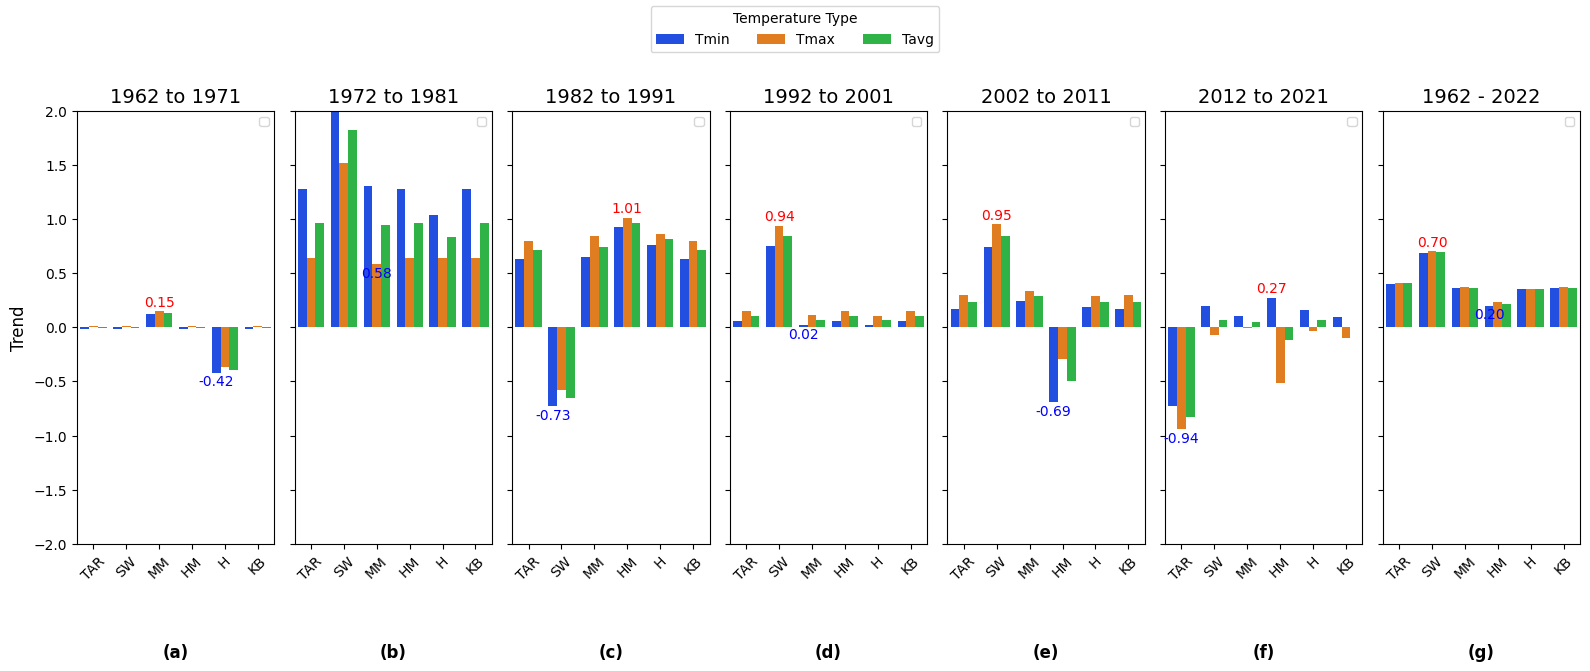

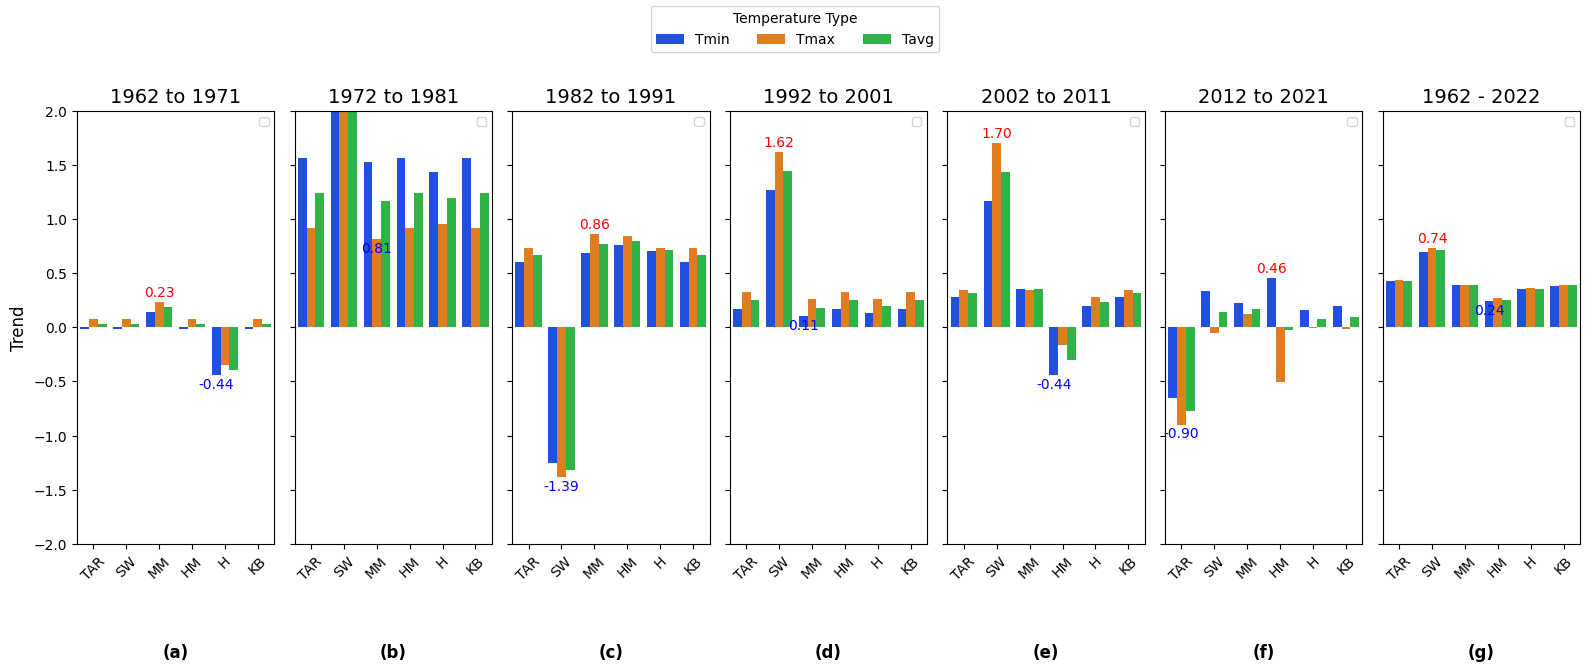

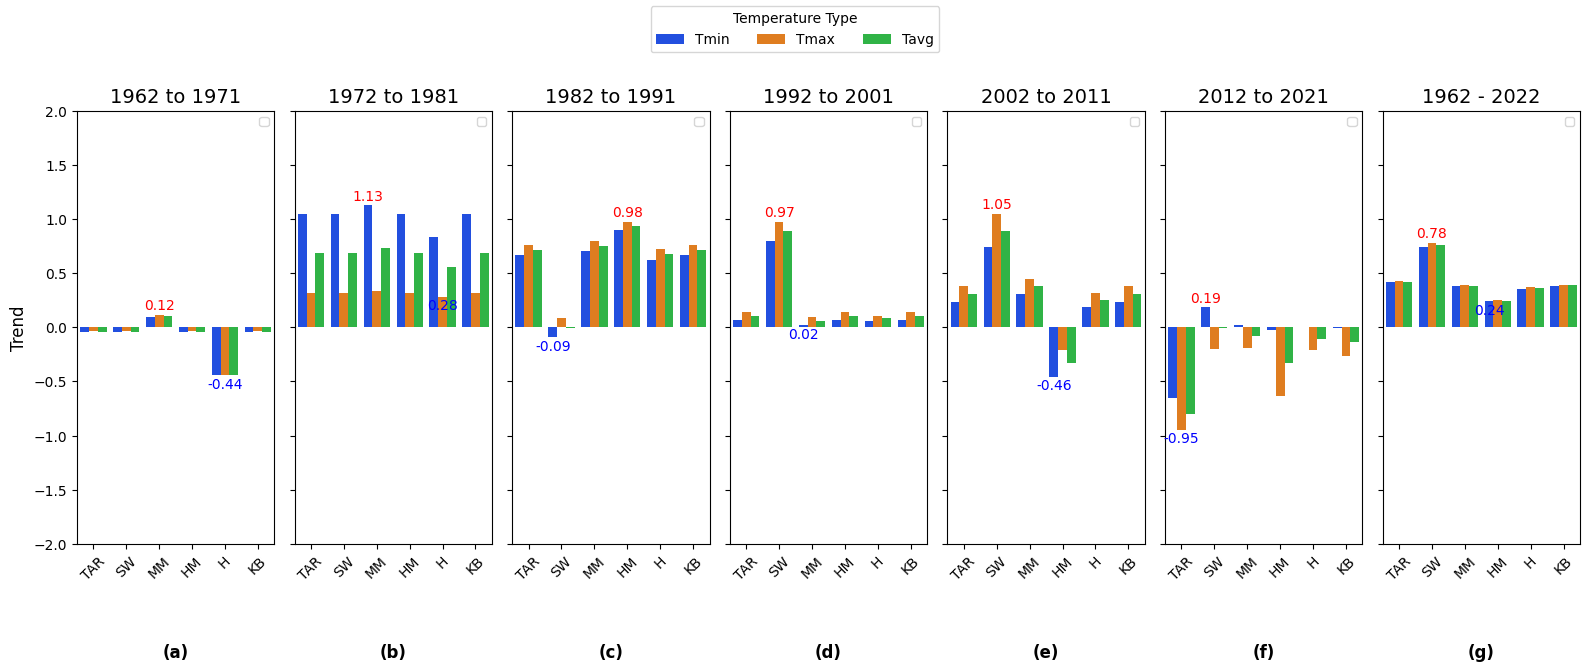

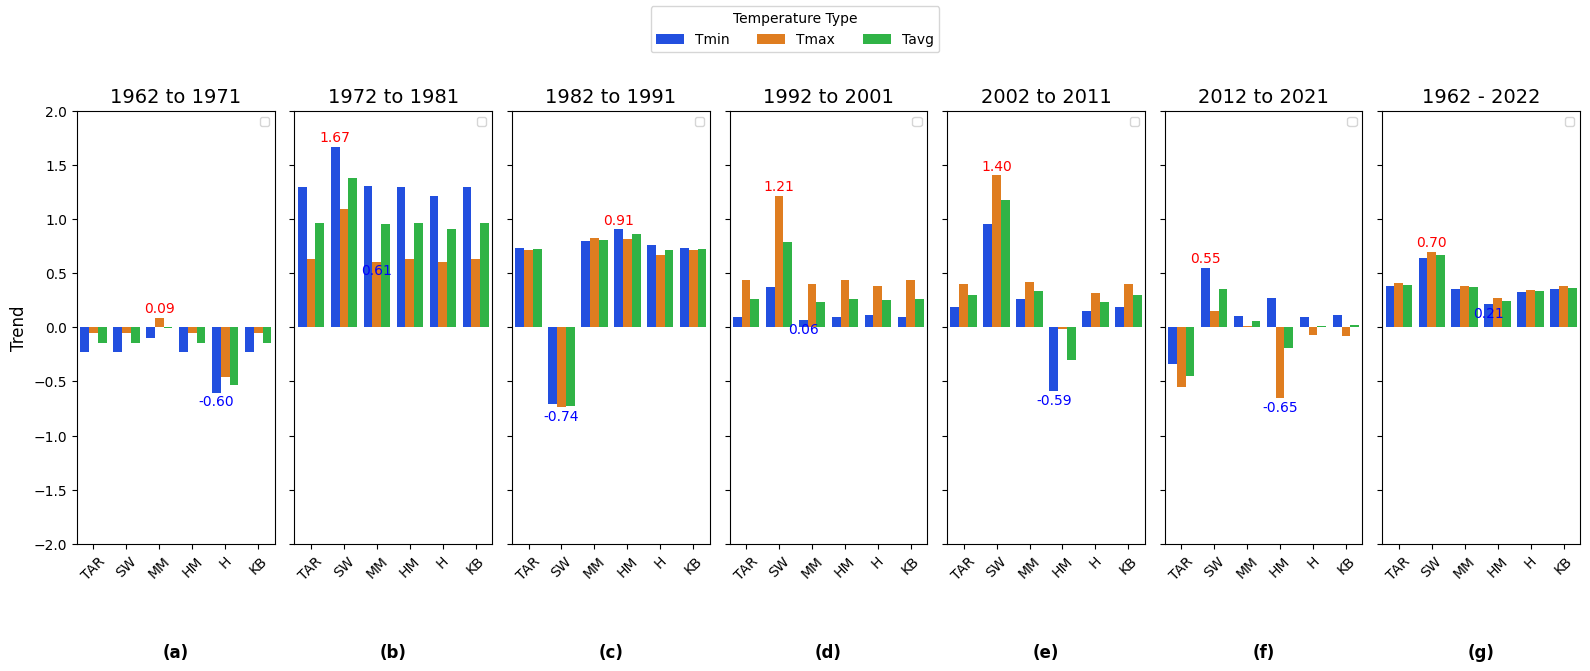

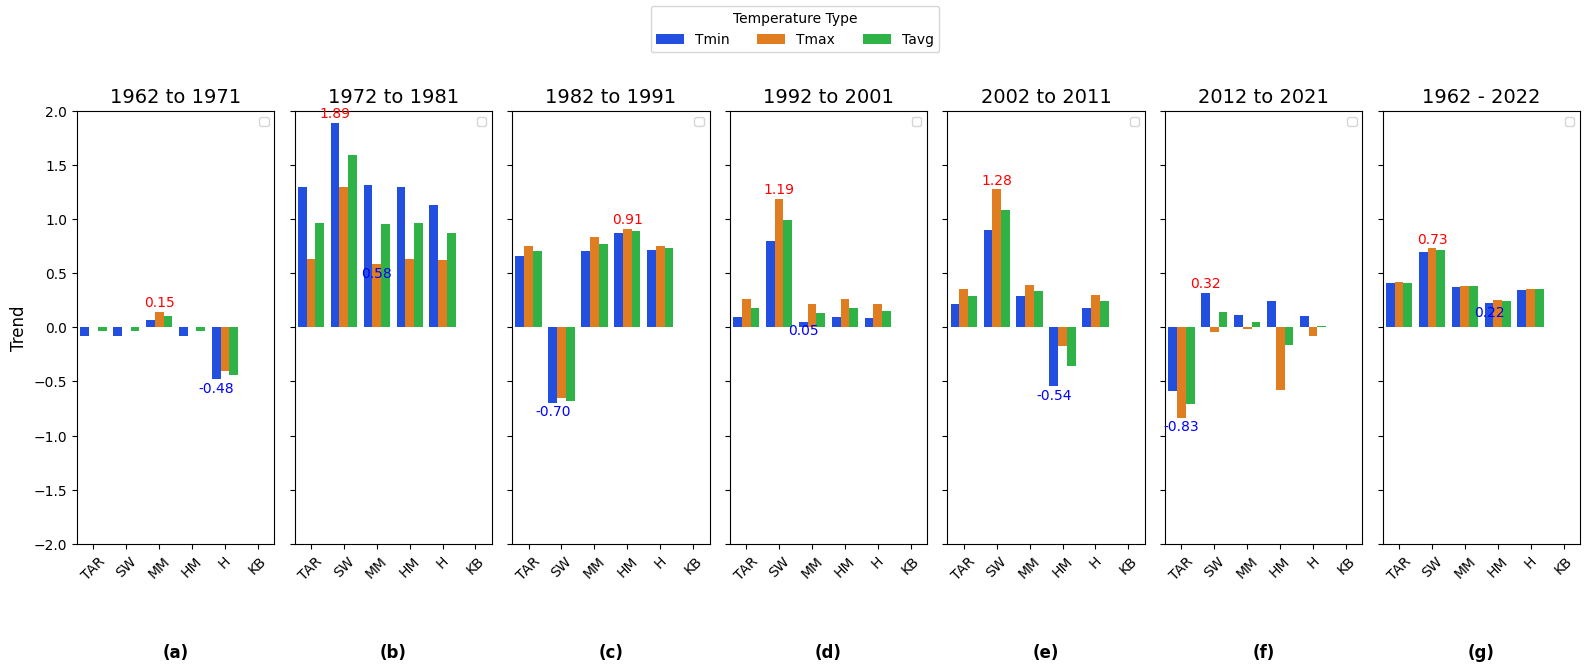

In [25]:

# Define the order of the 'Region' categories
region_order = ['TAR', 'SW', 'MM', 'HM', 'H', 'KB']  
# Calculate global min and max for y-axis limits
global_min = -2
global_max = 2
# Set plot style for publication
#sns.set(style="whitegrid")
# Get unique seasons and sorted decades
unique_seasons = df_long['Season'].unique()
unique_decades = df_long['Decade'].unique()  # Sort decades for chronological order
# Create plots for each unique season
for season in unique_seasons:
    # Create a figure for each season with subplots for each decade
    fig, axes = plt.subplots(nrows=1, ncols=len(unique_decades), figsize=(16, 7), sharey=True)
    
    # Create subplots for each decade
    for i, decade in enumerate(unique_decades):
        # Filter data for the current decade and season
        df_filtered = df_long[(df_long['Decade'] == decade) & (df_long['Season'] == season)]
        
        # Create the bar plot for the current season and decade
        bar_plot = sns.barplot(
            data=df_filtered, x='Region', y='Trend', hue='Temperature_Type',
            palette='bright', order=region_order, ax=axes[i]
        )
        
        # Set y-axis limits based on global min and max
        axes[i].set_ylim(global_min, global_max)
        
        # Set the subplot title
        axes[i].set_title(f'{decade}', fontsize=14)
        
        # Remove the x-axis label (Region)
        axes[i].set_xlabel('')  # Set to empty string
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=45)

        axes[i].legend([], title='', loc='upper right', fontsize='small')  # Empty legend

        # Get the maximum and minimum values from the filtered DataFrame
        max_value = df_filtered['Trend'].max()
        min_value = df_filtered['Trend'].min()
        # Define a vertical offset for annotations
        vertical_offset = 0.02  # Adjust this value as needed
        # Annotate the max and min values on the bars
        for p in bar_plot.patches:
            if p.get_height() == max_value:
                axes[i].annotate(f'{max_value:.2f}', 
                                 (p.get_x() + p.get_width() / 2., p.get_height()+ vertical_offset), 
                                 ha='center', va='bottom', fontsize=10, color='red')
            elif p.get_height() == min_value:
                axes[i].annotate(f'{min_value:.2f}', 
                                 (p.get_x() + p.get_width() / 2., p.get_height()+ vertical_offset - 0.04), 
                                 ha='center', va='top', fontsize=10, color='blue')

        

        
        # Only add y-axis label for the first subplot
        if i == 0:
            axes[i].set_ylabel('Trend', fontsize=12)

        # Add figure label inside parentheses
        axes[i].text(0.5, -0.25, f'({chr(97 + i)})', transform=axes[i].transAxes, 
                     fontsize=12, ha='center', va='center', weight='bold')

    # Create a legend based on the first subplot
    handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot 
    unique_labels = dict(zip(labels, handles))  # Keep unique labels only
    fig.legend(unique_labels.values(), unique_labels.keys(), title='Temperature Type', loc='upper center', ncol=len(unique_labels))
    
    # Set the overall figure title for the season
    #fig.suptitle(f'{season.title()} Trends Across Decades', fontsize=16)
    # File path to save the plot
    file_name = f"simple_plots_{season}_Trend.png"
    file_path = r'G:\fresh_start\paper\code_paper\plots\decades_plots\plot_seasonal'

    # Ensure the correct separator is added between the path and file name
    full_path = file_path + '\\' + file_name  # Use a backslash for Windows paths or `/` for cross-platform
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust to fit the title and labels
    
    # Save the plot
    #plt.savefig(full_path, dpi=1500)
        
    
    
    # Show the plot
    plt.show()


In [33]:
df15 = data_import.copy()
df15 = df15.drop(['month', 'adjusted_year', 'season'], axis=1)

# Display the modified DataFrame to confirm
print(df15.head())

        date  station regions       lat      long  elevation       Tmin  \
0 1962-01-01     1316   Tarai  26.82044  87.15917      105.0 -20.794283   
1 1962-01-02     1316   Tarai  26.82044  87.15917      105.0 -21.041333   
2 1962-01-03     1316   Tarai  26.82044  87.15917      105.0 -20.539140   
3 1962-01-04     1316   Tarai  26.82044  87.15917      105.0 -20.560894   
4 1962-01-05     1316   Tarai  26.82044  87.15917      105.0 -20.985399   

       Tmax       Tavg  year  
0 -8.535149 -14.664716  1962  
1 -9.286599 -15.163966  1962  
2 -9.407099 -14.973120  1962  
3 -7.914166 -14.237530  1962  
4 -9.087749 -15.036574  1962  


In [34]:
# Calculate the trends for each station and temperature type
stations_trend = []

# Group by station and apply the slope calculation for each temperature column
for station, group in df15.groupby('station'):
    slope_Tmin = calculate_slope(group['year'], group['Tmin'])
    slope_Tmax = calculate_slope(group['year'], group['Tmax'])
    slope_Tavg = calculate_slope(group['year'], group['Tavg'])
    
    # Store results in a dictionary
    trend_data = {
        'station': station,
        'lat': group['lat'].iloc[0],  # Latitude of the station
        'long': group['long'].iloc[0],  # Longitude of the station
        'elevation': group['elevation'].iloc[0],  # Elevation of the station
        'slope_Tmin': slope_Tmin,
        'slope_Tmax': slope_Tmax,
        'slope_Tavg': slope_Tavg
    }
    
    stations_trend.append(trend_data)

# Convert the list of results into a DataFrame
df_station_trends = pd.DataFrame(stations_trend)

# Display the trend results
print(df_station_trends)

    station        lat       long  elevation  slope_Tmin  slope_Tmax  \
0      1016  27.944561  85.595136     2574.0    0.233078    0.224971   
1      1024  27.616117  85.565503     1543.0    0.392285    0.399402   
2      1036  27.645134  85.620881      857.0    0.459986    0.382356   
3      1103  27.630447  86.232114     1877.0    0.103157    0.147189   
4      1123  27.394703  86.061233      497.0    0.593599    0.656622   
5      1124  27.633333  86.133333     1755.0    0.357707    0.375683   
6      1201  27.816670  86.716670     3450.0    0.457050    0.461248   
7      1206  27.308121  86.504225     1731.0    0.022306    0.079028   
8      1212  26.730538  86.934812      101.0    0.691178    0.727600   
9      1218  27.833330  86.766670     3857.0    0.457782    0.454903   
10     1219  27.505118  86.586215     2383.0    0.207929    0.280004   
11     1222  27.212522  86.791886     1612.0    0.403101    0.380250   
12     1225  27.816670  86.716670     3700.0    0.408010    0.42

In [35]:
gdf_4_kriging = gdf_nepal_in_koshi.copy()

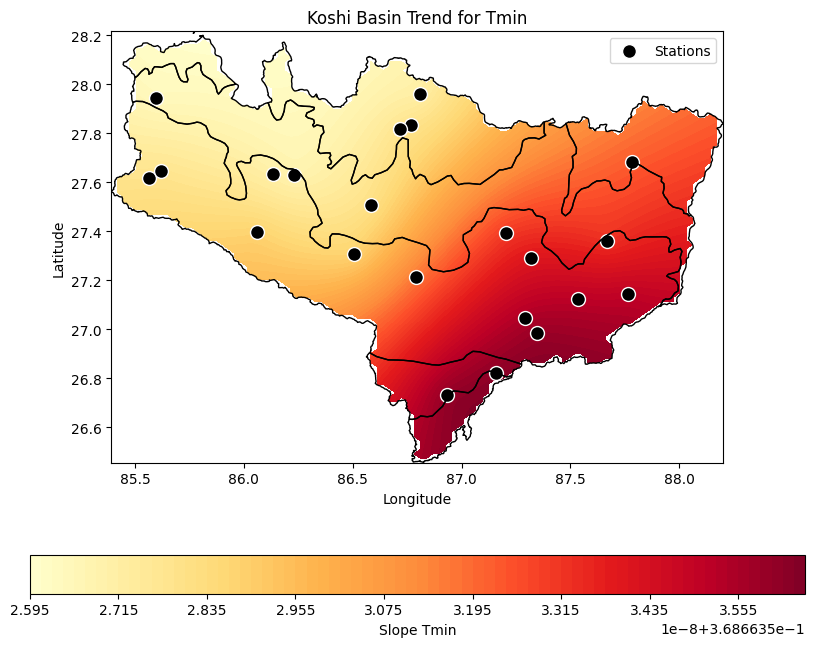

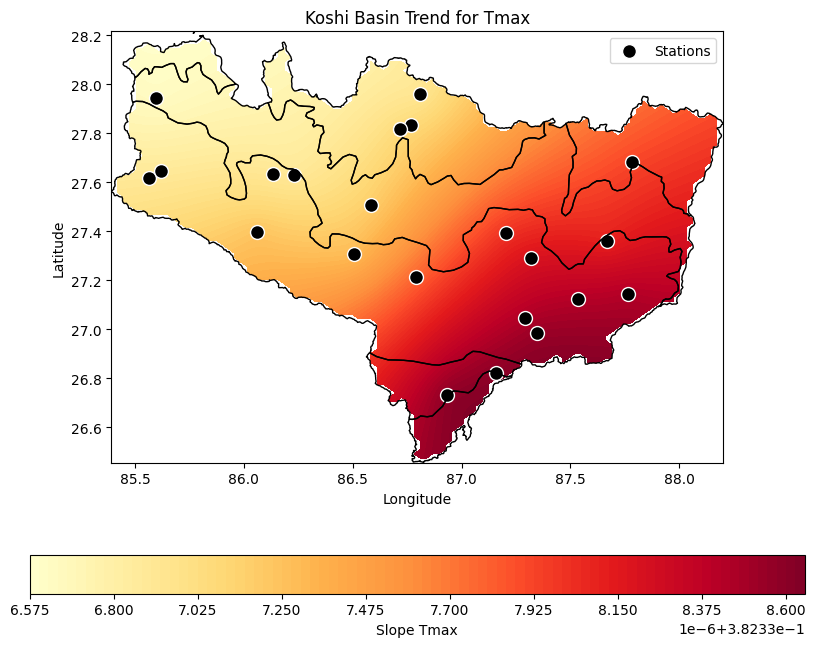

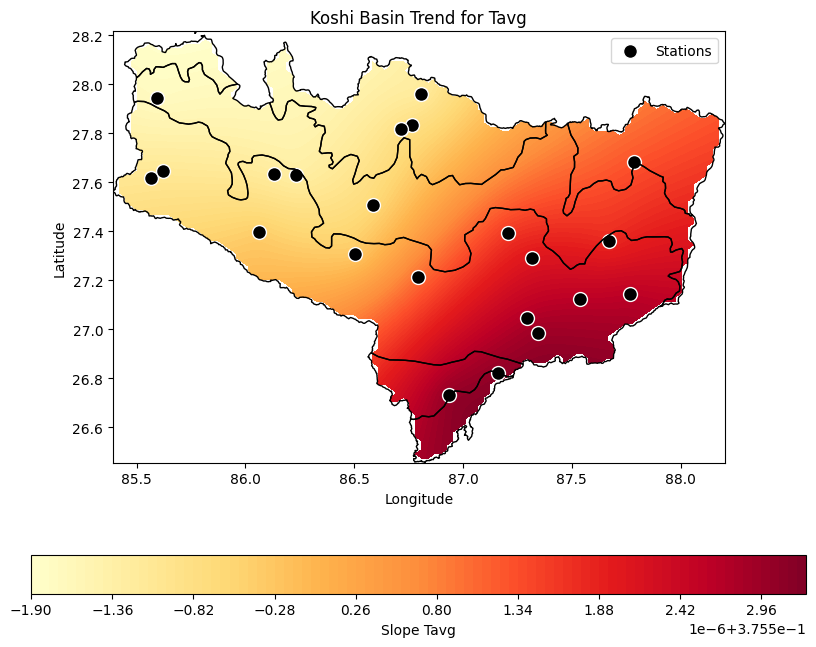

In [46]:


slope_columns = ['slope_Tmin', 'slope_Tmax', 'slope_Tavg']
titles = ['Koshi Basin Trend for Tmin', 'Koshi Basin Trend for Tmax', 'Koshi Basin Trend for Tavg']
colorbar_labels = ['Slope Tmin', 'Slope Tmax', 'Slope Tavg']

# Define a function to format colorbar ticks as integers
def integer_formatter(x, pos):
    return f'{int(x)}'

# Loop through the slope columns and create a plot for each
for i, col in enumerate(slope_columns):
    # Extract data for interpolation
    values = df_station_trends[col].values
    coords = np.array(list(zip(df_station_trends['long'], df_station_trends['lat'])))
    
    # Define grid based on boundary file
    minx, miny, maxx, maxy = gdf_4_kriging.total_bounds
    gridx = np.linspace(minx, maxx, 100)
    gridy = np.linspace(miny, maxy, 100)

    # Perform Ordinary Kriging
    OK = OrdinaryKriging(
        df_station_trends['long'], df_station_trends['lat'], values,
        variogram_model='linear', verbose=False, enable_plotting=False
    )

    # Interpolate values over the grid
    z, ss = OK.execute('grid', gridx, gridy)

    # Create a meshgrid for plotting
    X, Y = np.meshgrid(gridx, gridy)

    # Mask values outside the boundary
    boundary_polygon = gdf_4_kriging.geometry.union_all()  # Combine all boundary shapes into one
    mask = np.array([[boundary_polygon.contains(Point(x, y)) for x in gridx] for y in gridy])

    # Apply the mask to the interpolated values (keep only inside the boundary)
    z_masked = np.ma.masked_where(~mask, z)

    # Plot the masked interpolation inside the boundary
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, z_masked, cmap='YlOrRd', levels=100)

    # Plot the boundary and station points
    gdf_4_kriging.boundary.plot(ax=plt.gca(), color='black', linewidth=1)
    plt.scatter(df_station_trends['long'], df_station_trends['lat'], facecolors='black', edgecolors='white', marker='o', s=100, label='Stations')

    # Add labels and title
    plt.title(titles[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Horizontal colorbar
    cbar = plt.colorbar(contour, orientation='horizontal')
    cbar.set_label(colorbar_labels[i])

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()


In [47]:
df16 = data_import.copy()

In [49]:
# Calculate annual extreme data
annual_data = df.groupby(['year', 'regions']).agg({
    'Tmin': 'mean',
    'Tmax': 'mean',
    'Tavg': 'mean'
}).reset_index()

# List of regions
regions = annual_data['regions'].unique()

# Create an empty list to store the results
extreme_linear_reg_results = []

# Set up the plot for each region
for region in regions:
    region_data = annual_data[annual_data['regions'] == region]

    # Calculate regression for Tmin
    slope_Tmin, intercept_Tmin, _, _, _ = linregress(region_data['year'], region_data['Tmin'])
    equation_Tmin = f'Tmin: y = {slope_Tmin:.2f}x + {intercept_Tmin:.2f}'

    # Calculate regression for Tmax
    slope_Tmax, intercept_Tmax, _, _, _ = linregress(region_data['year'], region_data['Tmax'])
    equation_Tmax = f'Tmax: y = {slope_Tmax:.2f}x + {intercept_Tmax:.2f}'

    # Calculate regression for Tavg
    slope_Tavg, intercept_Tavg, _, _, _ = linregress(region_data['year'], region_data['Tavg'])
    equation_Tavg = f'Tavg: y = {slope_Tavg:.2f}x + {intercept_Tavg:.2f}'


    # Append the results for the current region to the list
    extreme_linear_reg_results.append({
        'Region': region,
        'Tavg_Slope': slope_Tavg,
        'Tavg_Intercept': intercept_Tavg,
        'Tmin_Slope': slope_Tmin,
        'Tmin_Intercept': intercept_Tmin,
        'Tmax_Slope': slope_Tmax,
        'Tmax_Intercept': intercept_Tmax,
        'Tavg_Equation': equation_Tavg,
        'Tmin_Equation': equation_Tmin,
        'Tmax_Equation': equation_Tmax
    })

# Convert the results list to a DataFrame
extreme_linear_reg_results_df = pd.DataFrame(extreme_linear_reg_results)
print(extreme_linear_reg_results_df)

            Region  Tavg_Slope  Tavg_Intercept  Tmin_Slope  Tmin_Intercept  \
0    High Mountain    0.352598     -685.535907    0.347228     -680.633142   
1             Hill    0.379206     -744.574630    0.373642     -738.345029   
2      Koshi Basin    0.377195     -739.413812    0.370085     -730.400704   
3  Middle Mountain    0.239652     -463.724465    0.223794     -437.447177   
4          Siwalik    0.710929    -1404.575991    0.691547    -1371.706873   
5            Tarai    0.413384     -822.768402    0.405699     -812.618843   

   Tmax_Slope  Tmax_Intercept               Tavg_Equation  \
0    0.357968     -690.438672   Tavg: y = 0.35x + -685.54   
1    0.384770     -750.804232   Tavg: y = 0.38x + -744.57   
2    0.384305     -748.426921   Tavg: y = 0.38x + -739.41   
3    0.255510     -490.001753   Tavg: y = 0.24x + -463.72   
4    0.730310    -1437.445108  Tavg: y = 0.71x + -1404.58   
5    0.421068     -832.917961   Tavg: y = 0.41x + -822.77   

                Tmin_Equa

In [50]:
# Create an empty list to store the Mann-Kendall results
extrene_mk_results = []

# Set up the extreme test for each region
for region in regions:
    region_data = annual_data[annual_data['regions'] == region]

    # Perform Mann-Kendall test for Tmin
    mk_Tmin = mk.original_test(region_data['Tmin'])
    mk_Tmax = mk.original_test(region_data['Tmax'])
    

    # Append the results for the current region to the list
    extrene_mk_results.append({
        'Region': region,
        'Tmin_Trend': mk_Tmin.trend,
        'Tmin_p-value': mk_Tmin.p,
        'Tmin_Slope': mk_Tmin.slope,
        'Tmax_Trend': mk_Tmax.trend,
        'Tmax_p-value': mk_Tmax.p
    })

# Convert the results list to a DataFrame
extrene_mk_results_df = pd.DataFrame(extrene_mk_results)



# Display the DataFrame
print(extrene_mk_results_df)

            Region  Tmin_Trend  Tmin_p-value  Tmin_Slope  Tmax_Trend  \
0    High Mountain  increasing  4.440892e-16    0.283058  increasing   
1             Hill  increasing  0.000000e+00    0.330175  increasing   
2      Koshi Basin  increasing  0.000000e+00    0.321387  increasing   
3  Middle Mountain  increasing  9.549284e-05    0.194224  increasing   
4          Siwalik  increasing  1.400622e-10    0.602751  increasing   
5            Tarai  increasing  0.000000e+00    0.355933  increasing   

   Tmax_p-value  
0  6.661338e-16  
1  0.000000e+00  
2  2.220446e-16  
3  1.287239e-05  
4  5.179073e-08  
5  2.220446e-16  
